## Integrating a simple harmonic oscillator and trying to infer the spring constant

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import scipy.optimize as so
%matplotlib inline
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad  
import tensorflow as tf
from tensorflow.contrib import autograph
import tfleapfrog_copy as tflf

In [6]:
tf.VERSION

'1.10.0'

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def potential_and_grad_py(position, k=1.0):
    #function that returns the potential and it's gradient at a given position
    return 0.5 * k * position**2, k*position

def leap(position, momentum, grad, potential_and_grad, step_size, k=1.0):
    momentum -= 0.5 * step_size * grad
    position += step_size * momentum
    potential, grad = potential_and_grad_py(position, k=k)
    momentum -= 0.5 * step_size * grad
    return position, momentum, potential, grad

def leapfrog(x0, v0, t_obs, phi_grad, dt, k=1.0):
    #function that takes initial conditions that takes us to the next position 
    x = [] 
    v = [] 
    t = [] 

    tprime = 0.0
    xprime = x0
    vprime = v0
    pot, grad = potential_and_grad_py(xprime, k=k)
    for to in t_obs:
        while tprime + dt < to:
            xprime, vprime, pot, grad = leap(xprime, vprime, grad, potential_and_grad_py, dt, k=k)
            tprime = tprime + dt        
        dt_tiny = to - tprime
        xsave, vsave, potsave, gradsave = leap(xprime, vprime, grad, potential_and_grad_py, dt_tiny, k=k)
        tsave = tprime + dt_tiny
        #print(xsave, vsave, tsave, potsave, gradsave)
        x.append(xsave.copy())
        v.append(vsave.copy())
        t.append(tsave.copy())
        #print(x, v)
    return np.array(x), np.array(v) #, np.array(t)

In [23]:
print(autograph.to_code(leapfrog))

from __future__ import print_function
import tensorflow as tf

def tf__leap(position, momentum, grad, potential_and_grad, step_size, k=1.0):
  try:
    with tf.name_scope('leap'):
      momentum -= 0.5 * step_size * grad
      position += step_size * momentum
      potential, grad = tf__potential_and_grad_py(position, k=k)
      momentum -= 0.5 * step_size * grad
      return position, momentum, potential, grad
  except:
    ag__.rewrite_graph_construction_error(ag_source_map__)

def tf__potential_and_grad_py(position, k=1.0):
  try:
    with tf.name_scope('potential_and_grad_py'):
      return 0.5 * k * position ** 2, k * position
  except:
    ag__.rewrite_graph_construction_error(ag_source_map__)

def tf__leapfrog(x0, v0, t_obs, phi_grad, dt, k=1.0):
  try:
    with tf.name_scope('leapfrog'):
      x = ag__.new_list([])
      v = ag__.new_list([])
      t = ag__.new_list([])
      tprime = 0.0
      xprime = x0
      vprime = v0
      pot, grad = tf__potential_and_grad_py(xprime, k=

In [35]:
#define step size of each leap and number of shos
s_size = 0.001      #resolution of each leap
n_shos = 1            #number of simple harmonic oscillators 

#generate initial velocities and momenta
np.random.seed(1)
position_val = np.float64(np.random.randn(n_shos))
momentum_val = np.float64(np.random.randn(n_shos))

#set spring constant
k_val = np.float64(0.0)

#generate times to observe SHO
max_time = 25
nobspoints = 100
t_obs = np.random.uniform(0, max_time, nobspoints)
t_obs.sort()


In [36]:
xleap, vleap = leapfrog(position_val, momentum_val, t_obs, potential_and_grad_py, s_size, k=0.0)

In [46]:
def potential_and_grad(position, k=np.float64(0.0)):
    #function that returns the potential and it's gradient at a given position
    return 0.5 * tf.multiply(k,tf.square(position)), tf.multiply(k,position)

np.random.seed(1)
position_val = np.float64(np.random.randn(n_shos))
momentum_val = np.float64(np.random.randn(n_shos))


#create placeholders for initial position and momentum to define model
position_0 = tf.Variable(position_val, dtype=np.float64, name='position_0')
momentum_0 = tf.Variable(momentum_val, dtype=np.float64, name='momentum_0')
k          = tf.Variable(k_val, dtype=np.float64, name = 'k')

dt       = tf.Variable(0.0, dtype=np.float64, name='dt')
step_size  = np.float64(0.01) #tf.placeholder(np.float32, name='step_size')
#grad     = tf.placeholder(np.float32, name='grad')

#new_ means model which you generated with placeholders, _val means instantiated value where you feed in param values

#define potential

new_potential, new_grad = potential_and_grad(position, k=k)

#define model, leapfrog_integrator is from hmc tensorflow stuff

new_position, new_momentum, new_potential, new_grad, x, v = tflf.leapfrog_integrator(
    step_size, dt, position_0, momentum_0, potential_and_grad, new_grad)

#start session
sess = tf.Session()

#calculate potential and gradient at these random positions 
potential_val, grad_val = sess.run([new_potential, new_grad],
                                 feed_dict={position_0: position_val, k: k_val})

#generate arrays to save values from model
positions = np.zeros([nobspoints, n_shos])
momenta   = np.zeros([nobspoints, n_shos])
grad      = np.zeros([nobspoints, n_shos])
potential = np.zeros([nobspoints, n_shos])

#run model on random initial positions and momenta
t_previous = 0.0
for i, t in enumerate(t_obs):
    print(t, t_previous)
    deltat = np.float64(t - t_previous)
    print(deltat)
    position_val, momentum_val, potential_val, grad_val, x_val, v_val = sess.run(
  [new_position, new_momentum, new_potential, new_grad, x, v],
  feed_dict = {position_0: position_val, momentum_0: momentum_val, 
               k: k_val, dt: deltat})#, grad:grad_val})
    positions[i] = x_val
    momenta[i] = v_val
    grad[i] = grad_val
    potential[i] = potential_val
    t_previous = t

# Plot positions and momenta 
fig, ax = plt.subplots(1,4, figsize=(10, 4))
ax[0].plot(t_obs, positions, 'o')
ax[0].plot(t_obs, xleap, 'ko')
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[1].set_xlabel('t')
ax[1].set_ylabel('y')
ax[1].plot(t_obs, momenta, 'o')
ax[1].plot(t_obs, vleap, 'ko')
ax[2].plot(t_obs, grad, 'o')
ax[3].plot(t_obs, potential, 'o')
plt.tight_layout()

ValueError: Input tensor 'position_0_3/read:0' enters the loop with shape (), but has shape <unknown> after one iteration. To allow the shape to vary across iterations, use the `shape_invariants` argument of tf.while_loop to specify a less-specific shape.

In [16]:
momentum_val.dtype

dtype('float64')

NameError: name 'positions' is not defined

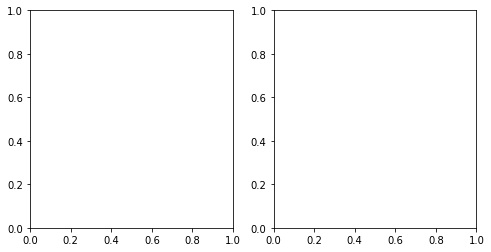

In [13]:
# Plot positions and momenta 
fig, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(t_obs, positions - xleap, 'o')

ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[1].set_xlabel('t')
ax[1].set_ylabel('y')
ax[1].plot(t_obs, momenta - vleap, 'o')
plt.tight_layout()